
#***DATASET : BITCOIN HISTORICAL DATA***  
[Dataset -> Kaggle](https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data)

#Contexto
Este dataset contiene información minuto a minuto de la criptomoneda Bitcoin, contiene variables para determinar el valor más alto, el más bajo, valor con el que inicia la medición (00:00 UTC <-Dia) y el valor con el que termina (23:59 UTC <-Dia). Existe una variable Volume que determina cuanto se ha transaccionado de la moneda en una ventana de tiempo.

#Variables

***HECHOS:*** "OPEN" "HIGH" "LOW" "CLOSE" "VOLUME" /
***DESCRIPTORES:*** "TIMESTAMP"

#Objetivo

Analizar la evolución del valor de la criptomoneda BITCOIN en un intervalo de tiempo diario, desde el año 2012 al año 2025, buscando identificar tendencias en el tiempo y evaluar la relación de dias transcurridos con el valor de cierre, mediante un modelo de regresión

Especificos:

-Transformar datos Unix (minutos) -> Dias
-Describir las variables principales OPEN, HIGH, LOW, CLOSE
-Explorar la relación del valor de cierre con los dias transcurridos
-Ajustar un modelo con la finalidad de evaluar si existe alguna tendencia entre paso de tiempo y valor del bitcoin



#Revision del dataset

In [13]:
#Importaciones relevantes
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm
import seaborn as sns
#modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LinearRegression


#activar drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Esto es para encontrar el dataset en drive
!ls "/content/drive/MyDrive/Semestre 6 Ing informatica/Inteligencia de negocios/Trabajo EV1 Bitcoin"

btcusd_1-min_data.csv  DatasetBitcoinAnalisis.ipynb


In [ ]:
# Ruta al archivo (ajústala según la ubicación exacta en tu Drive)
filepath = "/content/drive/MyDrive/Semestre 6 Ing informatica/Inteligencia de negocios/Trabajo EV1 Bitcoin/btcusd_1-min_data.csv"

# Cargar CSV completo
df = pd.read_csv(filepath)

print("Dimensiones:", df.shape)
print("Columnas:", df.columns.tolist())
print("\nPrimeras filas:")
print(df.head())

Dimensiones: (7189596, 6)
Columnas: ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']

Primeras filas:
      Timestamp  Open  High   Low  Close  Volume
0  1.325412e+09  4.58  4.58  4.58   4.58     0.0
1  1.325412e+09  4.58  4.58  4.58   4.58     0.0
2  1.325412e+09  4.58  4.58  4.58   4.58     0.0
3  1.325412e+09  4.58  4.58  4.58   4.58     0.0
4  1.325412e+09  4.58  4.58  4.58   4.58     0.0


Transformación de formato UNIX a datetime legible / Transformación de datos minuto a datos diarios ( para reducir cantidad de valores). Con este paso perdemos la información de un solo dia en total deberian ser 4995-1 (dia perdido) = 4994

In [ ]:
# Convertir Timestamp de Unix → datetime legible
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

# Ordenar por tiempo
df = df.sort_values('Timestamp')

# Poner Timestamp como índice para poder usar resample
df = df.set_index('Timestamp')

# Resumir a diario (OHLCV)
df_daily = df.resample('1D').agg({
    'Open': 'first',   # primer precio del día
    'High': 'max',     # precio máximo del día
    'Low': 'min',      # precio mínimo del día
    'Close': 'last',   # último precio del día
    'Volume': 'sum'    # volumen total del día (Transacciones)
})

print("Dimensiones diario:", df_daily.shape)
print(df_daily.head())
print(df_daily.tail())

Dimensiones diario: (4994, 5)
            Open  High   Low  Close      Volume
Timestamp                                      
2012-01-01  4.58  4.84  4.58   4.84   10.000000
2012-01-02  4.84  5.00  4.84   5.00   10.100000
2012-01-03  5.00  5.32  5.00   5.29  107.085281
2012-01-04  5.29  5.57  4.93   5.57  107.233260
2012-01-05  5.57  6.46  5.57   6.42   70.328742
                Open      High       Low     Close       Volume
Timestamp                                                      
2025-08-29  112581.0  112654.0  107488.0  108362.0  1977.324125
2025-08-30  108376.0  108924.0  107389.0  108827.0   790.830131
2025-08-31  108827.0  109503.0  108092.0  108269.0   747.367797
2025-09-01  108268.0  109907.0  107270.0  109244.0  1584.061806
2025-09-02  109255.0  111775.0  108426.0  111198.0  2117.614083


In [ ]:
# Agrega columna T que sirve para representar el dia de forma númerica, con esto espero poder trabajar más facilmente las fechas
df_daily['t'] = range(1, len(df_daily) + 1)

# Muestra primera y ultimas 5 filas
print(df_daily.head())
print(df_daily.tail())

            Open  High   Low  Close      Volume  t
Timestamp                                         
2012-01-01  4.58  4.84  4.58   4.84   10.000000  1
2012-01-02  4.84  5.00  4.84   5.00   10.100000  2
2012-01-03  5.00  5.32  5.00   5.29  107.085281  3
2012-01-04  5.29  5.57  4.93   5.57  107.233260  4
2012-01-05  5.57  6.46  5.57   6.42   70.328742  5
                Open      High       Low     Close       Volume     t
Timestamp                                                            
2025-08-29  112581.0  112654.0  107488.0  108362.0  1977.324125  4990
2025-08-30  108376.0  108924.0  107389.0  108827.0   790.830131  4991
2025-08-31  108827.0  109503.0  108092.0  108269.0   747.367797  4992
2025-09-01  108268.0  109907.0  107270.0  109244.0  1584.061806  4993
2025-09-02  109255.0  111775.0  108426.0  111198.0  2117.614083  4994


Exportar dataset nuevo con datos diarios a drive

In [ ]:
# Ruta donde quieres guardar el archivo en tu Drive
out_path = "/content/drive/MyDrive/Semestre 6 Ing informatica/Inteligencia de negocios/Trabajo EV1 Bitcoin/bitcoin_daily.csv"

# Exportar CSV
df_daily.to_csv(out_path)

print("✅ Archivo guardado en:", out_path)

✅ Archivo guardado en: /content/drive/MyDrive/Semestre 6 Ing informatica/Inteligencia de negocios/Trabajo EV1 Bitcoin/bitcoin_daily.csv


#Carga nuevo dataset con datos a diario

In [4]:
# Ruta al archivo nuevo en drive
filepath = "/content/drive/MyDrive/Semestre 6 Ing informatica/Inteligencia de negocios/Trabajo EV1 Bitcoin/bitcoin_daily.csv"

# Cargar CSV completo
df = pd.read_csv(filepath)

print("Dimensiones:", df.shape)
print("Columnas:", df.columns.tolist())
print("\nPrimeras filas:")
print(df.head())
print(df.tail())

Dimensiones: (4994, 7)
Columnas: ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 't']

Primeras filas:
    Timestamp  Open  High   Low  Close      Volume  t
0  2012-01-01  4.58  4.84  4.58   4.84   10.000000  1
1  2012-01-02  4.84  5.00  4.84   5.00   10.100000  2
2  2012-01-03  5.00  5.32  5.00   5.29  107.085281  3
3  2012-01-04  5.29  5.57  4.93   5.57  107.233260  4
4  2012-01-05  5.57  6.46  5.57   6.42   70.328742  5
       Timestamp      Open      High       Low     Close       Volume     t
4989  2025-08-29  112581.0  112654.0  107488.0  108362.0  1977.324125  4990
4990  2025-08-30  108376.0  108924.0  107389.0  108827.0   790.830131  4991
4991  2025-08-31  108827.0  109503.0  108092.0  108269.0   747.367797  4992
4992  2025-09-01  108268.0  109907.0  107270.0  109244.0  1584.061806  4993
4993  2025-09-02  109255.0  111775.0  108426.0  111198.0  2117.614083  4994


#Verificar valores

In [5]:
# Verificar valores nulos en las columnas
print(df.isnull().sum())

Timestamp    0
Open         0
High         0
Low          0
Close        0
Volume       0
t            0
dtype: int64


#Análisis posterior al ajuste del timestamp

In [ ]:
#Verificar si las filas estan ordenadas en orden Cronológico
modificado = False
if not df.index.is_monotonic_increasing:
    df = df.sort_index()
    modificad = True

print("Se ordenó el DataFrame por índice." if modificado else "Ya estaba ordenado (sin cambios).")

Ya estaba ordenado (sin cambios).


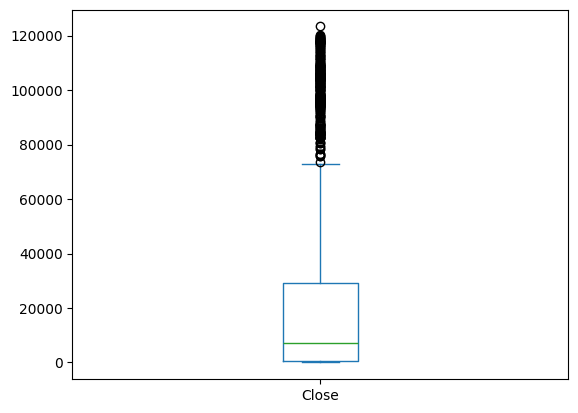

In [10]:
#boxplot
df['Close'].plot(kind='box')
plt.show()

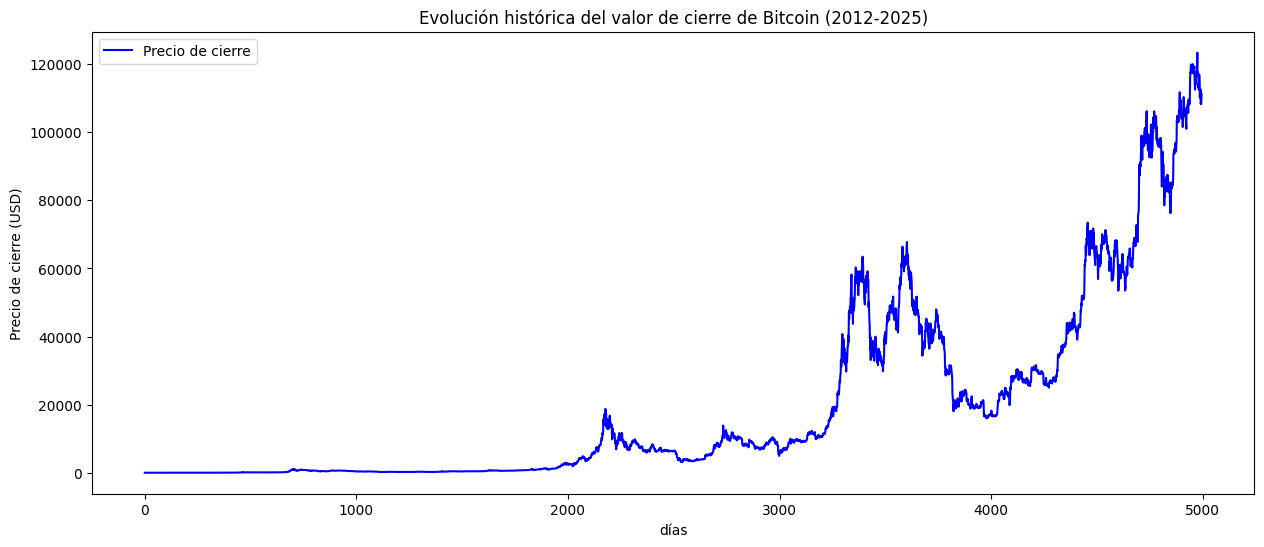

In [9]:
#Observar los valores desde año inicio a fin
plt.figure(figsize=(15,6))
plt.plot(df['t'], df['Close'], label="Precio de cierre", color="blue")
plt.title("Evolución histórica del valor de cierre de Bitcoin (2012-2025)")
plt.xlabel("días")
plt.ylabel("Precio de cierre (USD)")
plt.legend()
plt.show()


/tmp/ipython-input-3405790827.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


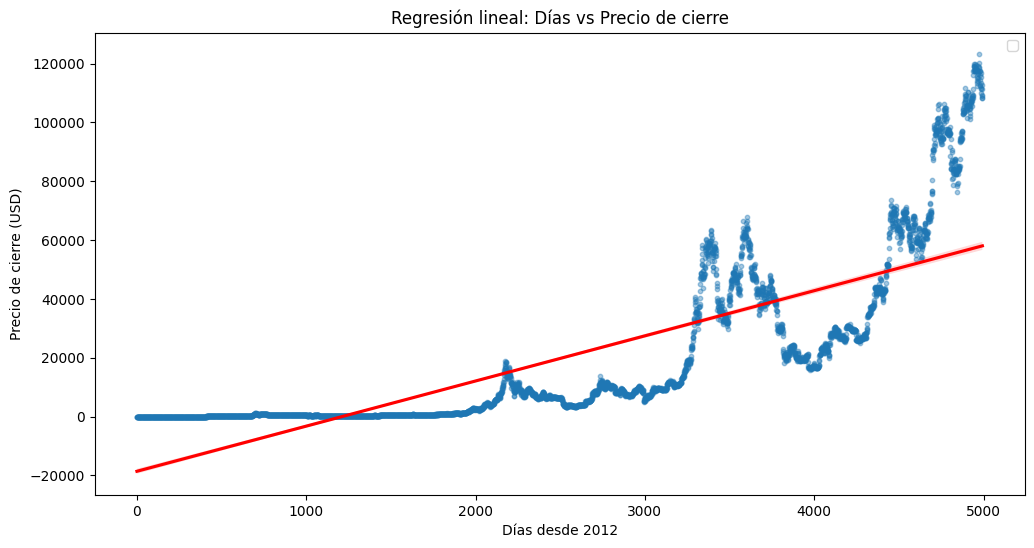

In [15]:
#Esto calcula la pendiente con regresión lineal simple
plt.figure(figsize=(12,6))
sns.regplot(
    x=np.arange(len(df)),  # eje X como numpy array
    y=df['Close'],         # eje Y como precios de cierre
    scatter=False,
    color="red",
    line_kws={'label':"Tendencia lineal"}
)
plt.scatter(np.arange(len(df)), df['Close'], alpha=0.4, s=10)
plt.title("Regresión lineal: Días vs Precio de cierre")
plt.xlabel("Días desde 2012")
plt.ylabel("Precio de cierre (USD)")
plt.legend()
plt.show()

In [ ]:
# Correlación de Pearson
r, p = pearsonr(df['t'], df['Close'])
print(f'Correlación Pearson r = {r:.3f} | p-valor = {p:.3g}')


Correlación Pearson r = 0.795 | p-valor = 0


In [ ]:
# Análisis estadístico descriptivo
descriptive_stats = df_daily.describe()
print("Análisis estadístico descriptivo:")
print(descriptive_stats)

Análisis estadístico descriptivo:
                Open           High            Low          Close  \
count    4994.000000    4994.000000    4994.000000    4994.000000   
mean    19699.826904   20140.646468   19241.572791   19721.999994   
std     27801.080165   28323.941379   27254.809532   27829.727711   
min         4.380000       4.380000       3.800000       4.380000   
25%       434.347500     444.142500     425.557500     434.625000   
50%      6998.225000    7234.060000    6775.340000    7003.440000   
75%     29349.347500   29960.000000   28998.825000   29363.540000   
max    123360.000000  124517.000000  118972.000000  123360.000000   

              Volume            t  
count    4994.000000  4994.000000  
mean     7474.630219  2497.500000  
std      9048.831692  1441.787953  
min         0.000000     1.000000  
25%      1998.719014  1249.250000  
50%      4571.868227  2497.500000  
75%      9651.611067  3745.750000  
max    127286.486533  4994.000000  


In [18]:
# Análisis estadístico descriptivo solo de la columna Close
descriptive_stats_close = df['Close'].describe()
print("Análisis estadístico descriptivo de Close:")
print(descriptive_stats_close)

Análisis estadístico descriptivo de Close:
count      4994.000000
mean      19721.999994
std       27829.727711
min           4.380000
25%         434.625000
50%        7003.440000
75%       29363.540000
max      123360.000000
Name: Close, dtype: float64


Aqui podemos observar varios datos relevantes principalmente el mean de close esde 19.721 USD, siendo el min y el max tan absurdamente distantes númericamente causa que la media se altere y hace que los datos esten muy dispersos. Se puede ver que la desviación estandar es de 27.829 lo que nos indica que la volatilidad de los datos es altisima y por ende los datos se encuentran muy dispersos.

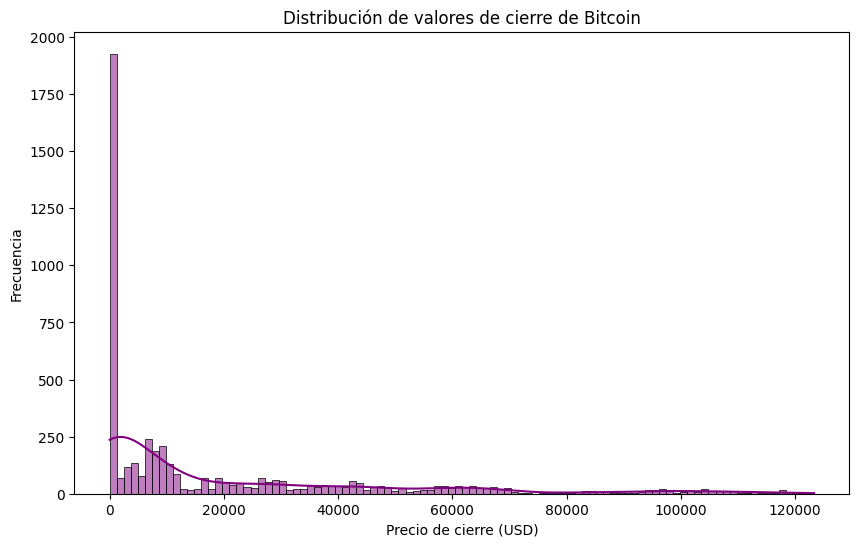

In [20]:
plt.figure(figsize=(10,6))
sns.histplot(df['Close'], bins=100, kde=True, color="purple")
plt.title("Distribución de valores de cierre de Bitcoin")
plt.xlabel("Precio de cierre (USD)")
plt.ylabel("Frecuencia")
plt.show()

#Pruebas con modelo

#Hubber

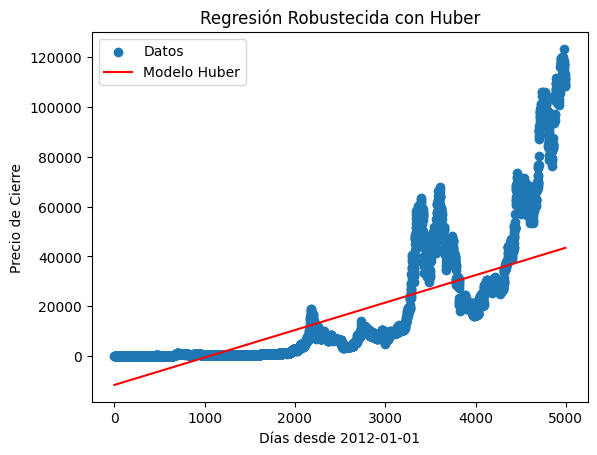

In [ ]:
# Modelo de regresión Huber
model = HuberRegressor()
model.fit(df[['t']], df['Close'])

# Realizar predicciones
y_pred = model.predict(df[['t']])

# Visualizar los resultados
plt.scatter(df['t'], df['Close'], label='Datos')
plt.plot(df['t'], y_pred, label='Modelo Huber', color='red')
plt.xlabel('Días desde 2012-01-01')
plt.ylabel('Precio de Cierre')
plt.title('Regresión Robustecida con Huber')
plt.legend()
plt.show()

In [ ]:
# Evaluación del modelo Huber
print("Coeficiente de Determinación (R²):", model.score(df[['t']], df['Close']))

Coeficiente de Determinación (R²): 0.5630129835245935


#LinearRegression

Coeficiente de regresión (pendiente): 15.348239927699632
Intercepto: -18610.229225437037


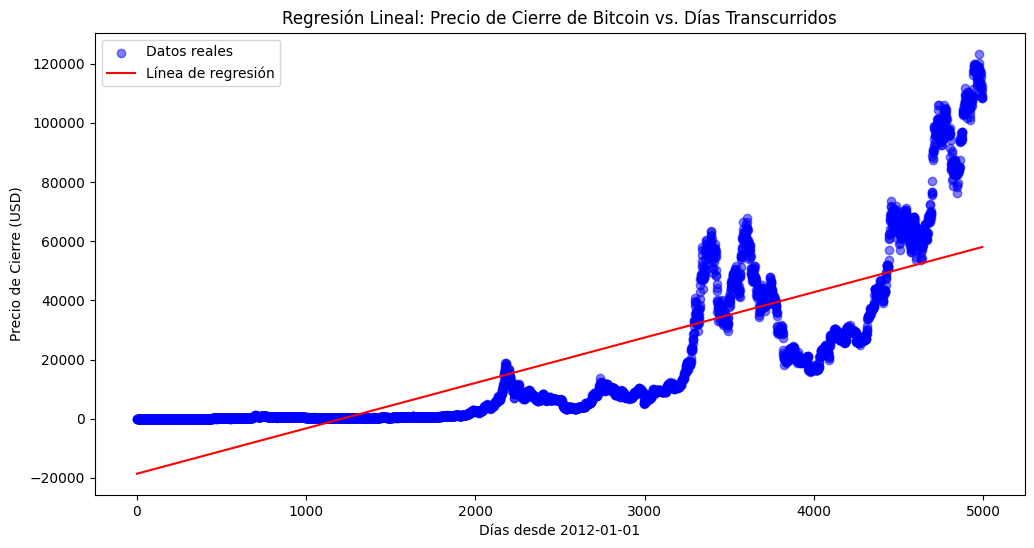

In [ ]:
# Variable independiente (t) y dependiente (Close)
X = df[['t']]  # Número de días transcurridos
y = df['Close']  # Precio de cierre

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Predicciones
y_pred = model.predict(X)

# Resultados
print("Coeficiente de regresión (pendiente):", model.coef_[0])
print("Intercepto:", model.intercept_)

# Graficar
plt.figure(figsize=(12, 6))
plt.scatter(X, y, color='blue', alpha=0.5, label='Datos reales')
plt.plot(X, y_pred, color='red', label='Línea de regresión')
plt.title("Regresión Lineal: Precio de Cierre de Bitcoin vs. Días Transcurridos")
plt.xlabel("Días desde 2012-01-01")
plt.ylabel("Precio de Cierre (USD)")
plt.legend()
plt.show()

In [ ]:
# Evaluación del modelo
mae = mean_absolute_error(y, y_pred)  # Error absoluto medio
rmse = np.sqrt(mean_squared_error(y, y_pred))  # Raíz del error cuadrático medio
r2 = r2_score(y, y_pred)  # Coeficiente de determinación

print(f"MAE (Error absoluto medio): {mae:.2f}")
print(f"RMSE (Raíz del error cuadrático medio): {rmse:.2f}")
print(f"R² (Coeficiente de determinación): {r2:.4f}")

MAE (Error absoluto medio): 13298.78
RMSE (Raíz del error cuadrático medio): 16874.48
R² (Coeficiente de determinación): 0.6323
